In [1]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2
import os
import sys

import clip

import importlib

import contextlib

import json
import os
import random


sys.path.insert(0, os.path.abspath('../..'))
sys.path.insert(0, os.path.abspath('../../..'))
import numpy as np
import torch
from collections import defaultdict
from utils import get_default_path
from utils import Stopwatch
import time

import datetime


import ai.stabledisco as sd
import ai.torchmodules as torchmodules
import ai.torchmodules.data as torchdata
import ai.torchmodules.utils as torchutils
import ai.stabledisco.utils as sdutils
import ai.stabledisco.data as sddata

import torch
import torch.nn as nn
import pandas as pd

from clip.clip import _tokenizer as clip_tokenizer
import ai.stabledisco.decoderpipeline as decoderpipeline

In [2]:
import re 

def parse_loss(training_log_lines):
    losses = []
    learning_rates = []

    for line in training_log_lines:
        matches = re.findall(fr"(?<=loss )\d+\.\d+", line)
        for match in matches:
            losses.append(float(match))
            
        matches = re.finditer(fr"(?<=Learning rate: \[)\d+\.\d+(e-?\d+)?(?=])", line)
        for match in matches:
            learning_rates.append(float(match.group(0)))
        
    return losses, learning_rates

In [102]:
training_log_lines = """
Starting training
Starting epoch 0
  500/25232 batches | batch/sec 31.05 | rem mins    13 | loss 0.0929 | ppl   1.0974
Learning rate: [3.7575120000000014e-05]
 1000/25232 batches | batch/sec 34.42 | rem mins    12 | loss 0.0927 | ppl   1.0972
Learning rate: [4.513512000000002e-05]
 1500/25232 batches | batch/sec 31.81 | rem mins    12 | loss 0.0935 | ppl   1.0980
Learning rate: [5.2695120000000025e-05]
 2000/25232 batches | batch/sec 31.50 | rem mins    12 | loss 0.0932 | ppl   1.0977
Learning rate: [6.025511999999995e-05]
 2500/25232 batches | batch/sec 31.59 | rem mins    12 | loss 0.0929 | ppl   1.0974
Learning rate: [6.781511999999994e-05]
 3000/25232 batches | batch/sec 32.15 | rem mins    12 | loss 0.0936 | ppl   1.0981
Learning rate: [7.537511999999996e-05]
 3500/25232 batches | batch/sec 31.46 | rem mins    12 | loss 0.0933 | ppl   1.0978
Learning rate: [8.293511999999997e-05]
 4000/25232 batches | batch/sec 31.59 | rem mins    11 | loss 0.0929 | ppl   1.0973
Learning rate: [9.049511999999996e-05]
 4500/25232 batches | batch/sec 31.33 | rem mins    11 | loss 0.0935 | ppl   1.0981
Learning rate: [9.805511999999998e-05]
 5000/25232 batches | batch/sec 32.32 | rem mins    10 | loss 0.0936 | ppl   1.0981
Learning rate: [0.00010561511999999998]
 5500/25232 batches | batch/sec 31.99 | rem mins    10 | loss 0.0933 | ppl   1.0978
Learning rate: [0.00011317511999999998]
 6000/25232 batches | batch/sec 31.57 | rem mins    10 | loss 0.0938 | ppl   1.0984
Learning rate: [0.00012073512]
 6500/25232 batches | batch/sec 33.25 | rem mins     9 | loss 0.0938 | ppl   1.0983
Learning rate: [0.00012829511999999999]
 7000/25232 batches | batch/sec 32.98 | rem mins     9 | loss 0.0932 | ppl   1.0977
Learning rate: [0.00013585512]
 7500/25232 batches | batch/sec 32.28 | rem mins     9 | loss 0.0936 | ppl   1.0981
Learning rate: [0.00014341512]
 8000/25232 batches | batch/sec 33.47 | rem mins     9 | loss 0.0937 | ppl   1.0983
Learning rate: [0.00015097512]
 8500/25232 batches | batch/sec 31.85 | rem mins     9 | loss 0.0941 | ppl   1.0986
Learning rate: [0.00015853512000000002]
 9000/25232 batches | batch/sec 31.68 | rem mins     9 | loss 0.0932 | ppl   1.0977
Learning rate: [0.00016609512]
 9500/25232 batches | batch/sec 36.57 | rem mins     7 | loss 0.0932 | ppl   1.0977
Learning rate: [0.00017365511999999992]
10000/25232 batches | batch/sec 31.51 | rem mins     8 | loss 0.0931 | ppl   1.0975
Learning rate: [0.00018121511999999993]
10500/25232 batches | batch/sec 31.43 | rem mins     8 | loss 0.0939 | ppl   1.0984
Learning rate: [0.00018877511999999995]
11000/25232 batches | batch/sec 31.71 | rem mins     7 | loss 0.0931 | ppl   1.0976
Learning rate: [0.00019633511999999994]
11500/25232 batches | batch/sec 32.18 | rem mins     7 | loss 0.0934 | ppl   1.0978
Learning rate: [0.00020389511999999995]
12000/25232 batches | batch/sec 32.63 | rem mins     7 | loss 0.0933 | ppl   1.0977
Learning rate: [0.00021145511999999994]
12500/25232 batches | batch/sec 32.85 | rem mins     6 | loss 0.0940 | ppl   1.0986
Learning rate: [0.00021898487999999993]
13000/25232 batches | batch/sec 31.83 | rem mins     6 | loss 0.0941 | ppl   1.0986
Learning rate: [0.00021142488]
13500/25232 batches | batch/sec 32.18 | rem mins     6 | loss 0.0931 | ppl   1.0976
Learning rate: [0.00020386488]
14000/25232 batches | batch/sec 32.61 | rem mins     6 | loss 0.0939 | ppl   1.0984
Learning rate: [0.00019630488000000002]
14500/25232 batches | batch/sec 32.40 | rem mins     6 | loss 0.0934 | ppl   1.0979
Learning rate: [0.00018874488]
15000/25232 batches | batch/sec 33.22 | rem mins     5 | loss 0.0936 | ppl   1.0981
Learning rate: [0.00018118487999999999]
15500/25232 batches | batch/sec 32.46 | rem mins     5 | loss 0.0943 | ppl   1.0989
Learning rate: [0.00017362488]
16000/25232 batches | batch/sec 32.30 | rem mins     5 | loss 0.0941 | ppl   1.0987
Learning rate: [0.00016606487999999998]
16500/25232 batches | batch/sec 33.68 | rem mins     4 | loss 0.0936 | ppl   1.0982
Learning rate: [0.00015850488]
17000/25232 batches | batch/sec 31.78 | rem mins     4 | loss 0.0929 | ppl   1.0974
Learning rate: [0.00015094487999999998]
17500/25232 batches | batch/sec 32.17 | rem mins     4 | loss 0.0931 | ppl   1.0976
Learning rate: [0.00014338487999999996]
18000/25232 batches | batch/sec 32.36 | rem mins     4 | loss 0.0929 | ppl   1.0973
Learning rate: [0.00013582487999999997]
18500/25232 batches | batch/sec 31.97 | rem mins     4 | loss 0.0931 | ppl   1.0976
Learning rate: [0.00012826487999999996]
19000/25232 batches | batch/sec 32.67 | rem mins     3 | loss 0.0931 | ppl   1.0975
Learning rate: [0.00012070487999999997]
19500/25232 batches | batch/sec 32.07 | rem mins     3 | loss 0.0933 | ppl   1.0978
Learning rate: [0.00011314487999999995]
20000/25232 batches | batch/sec 32.15 | rem mins     3 | loss 0.0928 | ppl   1.0972
Learning rate: [0.00010558487999999995]
20500/25232 batches | batch/sec 32.54 | rem mins     2 | loss 0.0928 | ppl   1.0972
Learning rate: [9.802487999999995e-05]
21000/25232 batches | batch/sec 32.36 | rem mins     2 | loss 0.0934 | ppl   1.0978
Learning rate: [9.046487999999993e-05]
21500/25232 batches | batch/sec 31.83 | rem mins     2 | loss 0.0928 | ppl   1.0972
Learning rate: [8.290487999999993e-05]
22000/25232 batches | batch/sec 32.16 | rem mins     2 | loss 0.0933 | ppl   1.0978
Learning rate: [7.534487999999993e-05]
22500/25232 batches | batch/sec 31.79 | rem mins     1 | loss 0.0932 | ppl   1.0976
Learning rate: [6.778488000000001e-05]
23000/25232 batches | batch/sec 32.29 | rem mins     1 | loss 0.0930 | ppl   1.0975
Learning rate: [6.022488e-05]
23500/25232 batches | batch/sec 33.02 | rem mins     1 | loss 0.0931 | ppl   1.0975
Learning rate: [5.2664879999999996e-05]
24000/25232 batches | batch/sec 31.82 | rem mins     1 | loss 0.0932 | ppl   1.0976
Learning rate: [4.510487999999999e-05]
24500/25232 batches | batch/sec 32.01 | rem mins     0 | loss 0.0931 | ppl   1.0975
Learning rate: [3.7544879999999985e-05]
25000/25232 batches | batch/sec 31.97 | rem mins     0 | loss 0.0936 | ppl   1.0981
Learning rate: [3.0010584000000068e-05]
  500/25232 batches | batch/sec 30.47 | rem mins    14 | loss 0.0927 | ppl   1.0971
Learning rate: [3.775807200000006e-05]
 1000/25232 batches | batch/sec 33.05 | rem mins    12 | loss 0.0924 | ppl   1.0968
Learning rate: [4.3050071999999946e-05]
 1500/25232 batches | batch/sec 33.04 | rem mins    12 | loss 0.0930 | ppl   1.0975
Learning rate: [4.8342072000000064e-05]
 2000/25232 batches | batch/sec 31.65 | rem mins    12 | loss 0.0927 | ppl   1.0971
Learning rate: [5.363407199999995e-05]
 2500/25232 batches | batch/sec 31.79 | rem mins    12 | loss 0.0925 | ppl   1.0969
Learning rate: [5.892607200000006e-05]
 3000/25232 batches | batch/sec 31.68 | rem mins    12 | loss 0.0931 | ppl   1.0976
Learning rate: [6.421807199999996e-05]
 3500/25232 batches | batch/sec 31.37 | rem mins    12 | loss 0.0927 | ppl   1.0971
Learning rate: [6.951007199999996e-05]
 4000/25232 batches | batch/sec 32.52 | rem mins    11 | loss 0.0923 | ppl   1.0967
Learning rate: [7.480207199999996e-05]
 4500/25232 batches | batch/sec 34.83 | rem mins    10 | loss 0.0932 | ppl   1.0976
Learning rate: [8.009407199999997e-05]
 5000/25232 batches | batch/sec 32.35 | rem mins    10 | loss 0.0932 | ppl   1.0977
Learning rate: [8.538607199999997e-05]
 5500/25232 batches | batch/sec 32.90 | rem mins    10 | loss 0.0929 | ppl   1.0973
Learning rate: [9.067807199999997e-05]
 6000/25232 batches | batch/sec 31.51 | rem mins    10 | loss 0.0934 | ppl   1.0978
Learning rate: [9.597007199999996e-05]
 6500/25232 batches | batch/sec 30.94 | rem mins    10 | loss 0.0933 | ppl   1.0978
Learning rate: [0.00010126207199999998]
 7000/25232 batches | batch/sec 31.75 | rem mins    10 | loss 0.0926 | ppl   1.0970
Learning rate: [0.00010655407199999998]
 7500/25232 batches | batch/sec 31.48 | rem mins     9 | loss 0.0926 | ppl   1.0971
Learning rate: [0.00011184607199999998]
 8000/25232 batches | batch/sec 32.69 | rem mins     9 | loss 0.0927 | ppl   1.0971
Learning rate: [0.00011713807199999999]
 8500/25232 batches | batch/sec 31.38 | rem mins     9 | loss 0.0928 | ppl   1.0972
Learning rate: [0.000122430072]
 9000/25232 batches | batch/sec 32.10 | rem mins     8 | loss 0.0920 | ppl   1.0964
Learning rate: [0.000127722072]
 9500/25232 batches | batch/sec 32.08 | rem mins     8 | loss 0.0925 | ppl   1.0969
Learning rate: [0.000133014072]
10000/25232 batches | batch/sec 32.57 | rem mins     8 | loss 0.0924 | ppl   1.0968
Learning rate: [0.000138306072]
10500/25232 batches | batch/sec 32.46 | rem mins     8 | loss 0.0931 | ppl   1.0976
Learning rate: [0.00014359807199999986]
11000/25232 batches | batch/sec 33.03 | rem mins     7 | loss 0.0924 | ppl   1.0968
Learning rate: [0.000148890072]
11500/25232 batches | batch/sec 32.32 | rem mins     7 | loss 0.0930 | ppl   1.0974
Learning rate: [0.0001541820719999999]
12000/25232 batches | batch/sec 32.64 | rem mins     7 | loss 0.0925 | ppl   1.0969
Learning rate: [0.000159474072]
12500/25232 batches | batch/sec 33.35 | rem mins     6 | loss 0.0933 | ppl   1.0978
Learning rate: [0.00015983392800000002]
13000/25232 batches | batch/sec 32.70 | rem mins     6 | loss 0.0931 | ppl   1.0976
Learning rate: [0.00015454192799999988]
13500/25232 batches | batch/sec 32.97 | rem mins     6 | loss 0.0924 | ppl   1.0968
Learning rate: [0.000149249928]
14000/25232 batches | batch/sec 32.38 | rem mins     6 | loss 0.0935 | ppl   1.0980
Learning rate: [0.00014395792799999987]
14500/25232 batches | batch/sec 32.20 | rem mins     6 | loss 0.0930 | ppl   1.0974
Learning rate: [0.00013866592799999998]
15000/25232 batches | batch/sec 32.94 | rem mins     5 | loss 0.0929 | ppl   1.0974
Learning rate: [0.00013337392799999987]
15500/25232 batches | batch/sec 33.03 | rem mins     5 | loss 0.0936 | ppl   1.0981
Learning rate: [0.000128081928]
16000/25232 batches | batch/sec 32.23 | rem mins     5 | loss 0.0934 | ppl   1.0979
Learning rate: [0.000122789928]
16500/25232 batches | batch/sec 32.07 | rem mins     5 | loss 0.0931 | ppl   1.0976
Learning rate: [0.000117497928]
17000/25232 batches | batch/sec 31.23 | rem mins     4 | loss 0.0926 | ppl   1.0970
Learning rate: [0.00011220592799999998]
17500/25232 batches | batch/sec 31.43 | rem mins     4 | loss 0.0926 | ppl   1.0971
Learning rate: [0.00010691392799999999]
18000/25232 batches | batch/sec 31.82 | rem mins     4 | loss 0.0921 | ppl   1.0964
Learning rate: [0.00010162192799999999]
18500/25232 batches | batch/sec 32.34 | rem mins     3 | loss 0.0923 | ppl   1.0967
Learning rate: [9.632992799999998e-05]
19000/25232 batches | batch/sec 33.12 | rem mins     3 | loss 0.0922 | ppl   1.0966
Learning rate: [9.103792799999998e-05]
19500/25232 batches | batch/sec 31.90 | rem mins     3 | loss 0.0923 | ppl   1.0967
Learning rate: [8.574592799999998e-05]
20000/25232 batches | batch/sec 30.92 | rem mins     3 | loss 0.0922 | ppl   1.0966
Learning rate: [8.045392799999998e-05]
20500/25232 batches | batch/sec 32.34 | rem mins     2 | loss 0.0922 | ppl   1.0966
Learning rate: [7.516192799999997e-05]
21000/25232 batches | batch/sec 32.24 | rem mins     2 | loss 0.0929 | ppl   1.0973
Learning rate: [6.986992799999997e-05]
21500/25232 batches | batch/sec 32.22 | rem mins     2 | loss 0.0923 | ppl   1.0967
Learning rate: [6.457792799999997e-05]
22000/25232 batches | batch/sec 32.27 | rem mins     2 | loss 0.0929 | ppl   1.0974
Learning rate: [5.9285927999999964e-05]
22500/25232 batches | batch/sec 31.82 | rem mins     1 | loss 0.0928 | ppl   1.0972
Learning rate: [5.3993927999999954e-05]
23000/25232 batches | batch/sec 32.21 | rem mins     1 | loss 0.0926 | ppl   1.0970
Learning rate: [4.8701928000000066e-05]
23500/25232 batches | batch/sec 32.53 | rem mins     1 | loss 0.0927 | ppl   1.0971
Learning rate: [4.340992799999995e-05]
24000/25232 batches | batch/sec 32.47 | rem mins     1 | loss 0.0928 | ppl   1.0973
Learning rate: [3.811792800000006e-05]
24500/25232 batches | batch/sec 33.01 | rem mins     0 | loss 0.0928 | ppl   1.0972
Learning rate: [3.282592799999994e-05]
25000/25232 batches | batch/sec 32.14 | rem mins     0 | loss 0.0934 | ppl   1.0978
Learning rate: [3.172625040000004e-05]
  500/25232 batches | batch/sec 30.93 | rem mins    13 | loss 0.0922 | ppl   1.0966
Learning rate: [3.714949200000003e-05]
 1000/25232 batches | batch/sec 32.97 | rem mins    12 | loss 0.0919 | ppl   1.0963
Learning rate: [4.085389200000003e-05]
 1500/25232 batches | batch/sec 32.30 | rem mins    12 | loss 0.0924 | ppl   1.0968
Learning rate: [4.455829199999995e-05]
 2000/25232 batches | batch/sec 32.96 | rem mins    12 | loss 0.0920 | ppl   1.0964
Learning rate: [4.826269199999995e-05]
 2500/25232 batches | batch/sec 33.25 | rem mins    11 | loss 0.0920 | ppl   1.0964
Learning rate: [5.196709199999996e-05]
 3000/25232 batches | batch/sec 32.48 | rem mins    11 | loss 0.0926 | ppl   1.0970
Learning rate: [5.5671491999999955e-05]
 3500/25232 batches | batch/sec 32.33 | rem mins    11 | loss 0.0922 | ppl   1.0966
Learning rate: [5.937589199999995e-05]
 4000/25232 batches | batch/sec 32.99 | rem mins    11 | loss 0.0918 | ppl   1.0961
Learning rate: [6.308029199999996e-05]
 4500/25232 batches | batch/sec 32.55 | rem mins    11 | loss 0.0927 | ppl   1.0972
Learning rate: [6.678469199999996e-05]
 5000/25232 batches | batch/sec 32.85 | rem mins    10 | loss 0.0929 | ppl   1.0973
Learning rate: [7.048909199999995e-05]
 5500/25232 batches | batch/sec 32.98 | rem mins    10 | loss 0.0925 | ppl   1.0969
Learning rate: [7.419349199999997e-05]
 6000/25232 batches | batch/sec 32.24 | rem mins    10 | loss 0.0930 | ppl   1.0975
Learning rate: [7.789789199999996e-05]
 6500/25232 batches | batch/sec 32.60 | rem mins    10 | loss 0.0930 | ppl   1.0974
Learning rate: [8.160229199999997e-05]
 7000/25232 batches | batch/sec 32.53 | rem mins     9 | loss 0.0922 | ppl   1.0966
Learning rate: [8.530669199999997e-05]
10000/25232 batches | batch/sec 32.69 | rem mins     8 | loss 0.0917 | ppl   1.0960
Learning rate: [0.00010753309199999999]
10500/25232 batches | batch/sec 32.72 | rem mins     8 | loss 0.0926 | ppl   1.0971
Learning rate: [0.00011123749199999998]
11000/25232 batches | batch/sec 33.17 | rem mins     7 | loss 0.0918 | ppl   1.0961
Learning rate: [0.000114941892]
11500/25232 batches | batch/sec 32.32 | rem mins     7 | loss 0.0923 | ppl   1.0967
Learning rate: [0.00011864629199999999]
12000/25232 batches | batch/sec 32.88 | rem mins     7 | loss 0.0921 | ppl   1.0964
Learning rate: [0.00012235069199999996]
12500/25232 batches | batch/sec 32.34 | rem mins     7 | loss 0.0927 | ppl   1.0972
Learning rate: [0.00011916490799999994]
13000/25232 batches | batch/sec 31.55 | rem mins     6 | loss 0.0929 | ppl   1.0974
Learning rate: [0.00011546050799999992]
13500/25232 batches | batch/sec 32.60 | rem mins     6 | loss 0.0920 | ppl   1.0964
Learning rate: [0.00011175610799999993]
14000/25232 batches | batch/sec 31.64 | rem mins     6 | loss 0.0929 | ppl   1.0974
Learning rate: [0.000108051708]
14500/25232 batches | batch/sec 32.41 | rem mins     6 | loss 0.0924 | ppl   1.0968
Learning rate: [0.00010434730800000001]
15000/25232 batches | batch/sec 32.14 | rem mins     5 | loss 0.0923 | ppl   1.0967
Learning rate: [0.00010064290800000001]
15500/25232 batches | batch/sec 32.59 | rem mins     5 | loss 0.0932 | ppl   1.0977
Learning rate: [9.693850799999999e-05]
16000/25232 batches | batch/sec 31.97 | rem mins     5 | loss 0.0928 | ppl   1.0972
Learning rate: [9.3234108e-05]
16500/25232 batches | batch/sec 33.05 | rem mins     4 | loss 0.0926 | ppl   1.0970
Learning rate: [8.952970799999999e-05]
17000/25232 batches | batch/sec 33.47 | rem mins     4 | loss 0.0921 | ppl   1.0964
Learning rate: [8.5825308e-05]
17500/25232 batches | batch/sec 32.21 | rem mins     4 | loss 0.0916 | ppl   1.0960
Learning rate: [8.212090799999998e-05]
18000/25232 batches | batch/sec 34.23 | rem mins     4 | loss 0.0910 | ppl   1.0953
Learning rate: [7.841650799999999e-05]
18500/25232 batches | batch/sec 32.73 | rem mins     3 | loss 0.0913 | ppl   1.0956
Learning rate: [7.471210799999999e-05]
19000/25232 batches | batch/sec 32.99 | rem mins     3 | loss 0.0913 | ppl   1.0956
Learning rate: [7.100770799999998e-05]
19500/25232 batches | batch/sec 32.57 | rem mins     3 | loss 0.0919 | ppl   1.0963
Learning rate: [6.730330799999999e-05]
20000/25232 batches | batch/sec 32.08 | rem mins     3 | loss 0.0918 | ppl   1.0962
Learning rate: [6.359890799999997e-05]
20500/25232 batches | batch/sec 32.03 | rem mins     2 | loss 0.0919 | ppl   1.0963
Learning rate: [5.989450799999998e-05]
21000/25232 batches | batch/sec 31.40 | rem mins     2 | loss 0.0926 | ppl   1.0970
Learning rate: [5.619010799999998e-05]
21500/25232 batches | batch/sec 31.41 | rem mins     2 | loss 0.0921 | ppl   1.0965
Learning rate: [5.248570799999998e-05]
22000/25232 batches | batch/sec 31.85 | rem mins     2 | loss 0.0926 | ppl   1.0970
Learning rate: [4.878130799999998e-05]
22500/25232 batches | batch/sec 32.54 | rem mins     1 | loss 0.0924 | ppl   1.0968
Learning rate: [4.507690799999998e-05]
23000/25232 batches | batch/sec 32.35 | rem mins     1 | loss 0.0923 | ppl   1.0967
Learning rate: [4.137250799999997e-05]
23500/25232 batches | batch/sec 31.67 | rem mins     1 | loss 0.0925 | ppl   1.0969
Learning rate: [3.7668107999999974e-05]
24000/25232 batches | batch/sec 31.78 | rem mins     1 | loss 0.0926 | ppl   1.0971
Learning rate: [3.396370799999997e-05]
24500/25232 batches | batch/sec 32.53 | rem mins     0 | loss 0.0926 | ppl   1.0970
Learning rate: [3.0259307999999968e-05]
25000/25232 batches | batch/sec 31.97 | rem mins     0 | loss 0.0931 | ppl   1.0975
Learning rate: [3.241156440000002e-05]
  500/25232 batches | batch/sec 29.58 | rem mins    14 | loss 0.0917 | ppl   1.0960
Learning rate: [3.620783352000001e-05]
 1000/25232 batches | batch/sec 31.45 | rem mins    13 | loss 0.0914 | ppl   1.0957
Learning rate: [3.880091352000007e-05]
 1500/25232 batches | batch/sec 32.36 | rem mins    12 | loss 0.0918 | ppl   1.0961
Learning rate: [4.1393993520000016e-05]
 2000/25232 batches | batch/sec 32.31 | rem mins    12 | loss 0.0913 | ppl   1.0956
Learning rate: [4.398707351999996e-05]
 2500/25232 batches | batch/sec 32.54 | rem mins    12 | loss 0.0917 | ppl   1.0960
Learning rate: [4.658015352000002e-05]
 3000/25232 batches | batch/sec 31.61 | rem mins    12 | loss 0.0923 | ppl   1.0967
Learning rate: [4.9173233519999966e-05]
 3500/25232 batches | batch/sec 31.36 | rem mins    12 | loss 0.0919 | ppl   1.0962
Learning rate: [5.176631352000002e-05]
 4000/25232 batches | batch/sec 31.93 | rem mins    11 | loss 0.0914 | ppl   1.0957
Learning rate: [5.4359393519999965e-05]
 4500/25232 batches | batch/sec 31.07 | rem mins    11 | loss 0.0926 | ppl   1.0970
Learning rate: [5.695247351999991e-05]
 5000/25232 batches | batch/sec 31.75 | rem mins    11 | loss 0.0926 | ppl   1.0970
Learning rate: [5.954555351999997e-05]
 5500/25232 batches | batch/sec 30.83 | rem mins    11 | loss 0.0921 | ppl   1.0964
Learning rate: [6.213863352000002e-05]
 6000/25232 batches | batch/sec 31.37 | rem mins    10 | loss 0.0925 | ppl   1.0969
Learning rate: [6.473171351999998e-05]
 6500/25232 batches | batch/sec 33.24 | rem mins     9 | loss 0.0925 | ppl   1.0970
Learning rate: [6.732479351999992e-05]
 7000/25232 batches | batch/sec 31.33 | rem mins    10 | loss 0.0918 | ppl   1.0961
Learning rate: [6.991787351999997e-05]
 7500/25232 batches | batch/sec 31.16 | rem mins     9 | loss 0.0920 | ppl   1.0963
Learning rate: [7.251095352000003e-05]
 8000/25232 batches | batch/sec 31.97 | rem mins     9 | loss 0.0920 | ppl   1.0964
Learning rate: [7.510403351999997e-05]
 8500/25232 batches | batch/sec 31.34 | rem mins     9 | loss 0.0922 | ppl   1.0966
Learning rate: [7.769711351999992e-05]
 9000/25232 batches | batch/sec 31.20 | rem mins     9 | loss 0.0913 | ppl   1.0956
Learning rate: [8.029019351999997e-05]
 9500/25232 batches | batch/sec 32.11 | rem mins     8 | loss 0.0920 | ppl   1.0964
Learning rate: [8.288327352000004e-05]
12500/25232 batches | batch/sec 33.24 | rem mins     6 | loss 0.0919 | ppl   1.0963
Learning rate: [9.121224648000002e-05]
13000/25232 batches | batch/sec 32.10 | rem mins     6 | loss 0.0921 | ppl   1.0964
Learning rate: [8.861916647999995e-05]
13500/25232 batches | batch/sec 32.82 | rem mins     6 | loss 0.0911 | ppl   1.0954
Learning rate: [8.60260864799999e-05]
14000/25232 batches | batch/sec 31.02 | rem mins     6 | loss 0.0924 | ppl   1.0968
Learning rate: [8.343300647999995e-05]
14500/25232 batches | batch/sec 32.22 | rem mins     6 | loss 0.0919 | ppl   1.0963
Learning rate: [8.083992648000001e-05]
15000/25232 batches | batch/sec 32.62 | rem mins     5 | loss 0.0919 | ppl   1.0962
Learning rate: [7.824684647999995e-05]
15500/25232 batches | batch/sec 32.62 | rem mins     5 | loss 0.0927 | ppl   1.0971
Learning rate: [7.565376648000001e-05]
16000/25232 batches | batch/sec 32.35 | rem mins     5 | loss 0.0924 | ppl   1.0968
Learning rate: [7.306068647999994e-05]
16500/25232 batches | batch/sec 32.30 | rem mins     5 | loss 0.0922 | ppl   1.0965
Learning rate: [7.046760648000001e-05]
17000/25232 batches | batch/sec 32.66 | rem mins     4 | loss 0.0917 | ppl   1.0961
Learning rate: [6.787452648000005e-05]
17500/25232 batches | batch/sec 32.95 | rem mins     4 | loss 0.0914 | ppl   1.0957
Learning rate: [6.528144648e-05]
18000/25232 batches | batch/sec 32.61 | rem mins     4 | loss 0.0910 | ppl   1.0952
Learning rate: [6.268836647999995e-05]
18500/25232 batches | batch/sec 32.62 | rem mins     3 | loss 0.0914 | ppl   1.0957
Learning rate: [6.009528648e-05]
19000/25232 batches | batch/sec 32.79 | rem mins     3 | loss 0.0913 | ppl   1.0956
Learning rate: [5.7502206480000055e-05]
19500/25232 batches | batch/sec 32.90 | rem mins     3 | loss 0.0918 | ppl   1.0962
Learning rate: [5.4909126479999995e-05]
20000/25232 batches | batch/sec 32.48 | rem mins     3 | loss 0.0917 | ppl   1.0961
Learning rate: [5.2316046479999935e-05]
20500/25232 batches | batch/sec 32.75 | rem mins     2 | loss 0.0915 | ppl   1.0958
Learning rate: [4.972296647999999e-05]
21000/25232 batches | batch/sec 32.04 | rem mins     2 | loss 0.0921 | ppl   1.0965
Learning rate: [4.7129886480000045e-05]
21500/25232 batches | batch/sec 31.95 | rem mins     2 | loss 0.0916 | ppl   1.0960
Learning rate: [4.453680647999999e-05]
22000/25232 batches | batch/sec 32.50 | rem mins     2 | loss 0.0922 | ppl   1.0966
Learning rate: [4.194372647999993e-05]
22500/25232 batches | batch/sec 31.82 | rem mins     1 | loss 0.0921 | ppl   1.0965
Learning rate: [3.935064647999999e-05]
23000/25232 batches | batch/sec 31.99 | rem mins     1 | loss 0.0919 | ppl   1.0962
Learning rate: [3.675756648000005e-05]
23500/25232 batches | batch/sec 32.33 | rem mins     1 | loss 0.0921 | ppl   1.0965
Learning rate: [3.416448647999999e-05]
24000/25232 batches | batch/sec 31.97 | rem mins     1 | loss 0.0923 | ppl   1.0967
Learning rate: [3.157140647999993e-05]
24500/25232 batches | batch/sec 32.21 | rem mins     0 | loss 0.0922 | ppl   1.0966
Learning rate: [3.071517146400001e-05]
25000/25232 batches | batch/sec 32.05 | rem mins     0 | loss 0.0929 | ppl   1.0973
Learning rate: [3.253032746399997e-05]
  500/25232 batches | batch/sec 30.27 | rem mins    14 | loss 0.0913 | ppl   1.0956
Learning rate: [3.5187715847999964e-05]
 1000/25232 batches | batch/sec 33.38 | rem mins    12 | loss 0.0909 | ppl   1.0951
Learning rate: [3.7002871848000007e-05]
 1500/25232 batches | batch/sec 33.40 | rem mins    12 | loss 0.0913 | ppl   1.0956
Learning rate: [3.881802784799997e-05]
 2000/25232 batches | batch/sec 31.74 | rem mins    12 | loss 0.0908 | ppl   1.0951
Learning rate: [4.0633183848000004e-05]
 2500/25232 batches | batch/sec 31.65 | rem mins    12 | loss 0.0912 | ppl   1.0954
Learning rate: [4.2448339847999966e-05]
 3000/25232 batches | batch/sec 31.65 | rem mins    12 | loss 0.0915 | ppl   1.0958
Learning rate: [4.426349584800001e-05]
 3500/25232 batches | batch/sec 32.22 | rem mins    11 | loss 0.0910 | ppl   1.0952
Learning rate: [4.607865184799996e-05]
 4000/25232 batches | batch/sec 32.17 | rem mins    11 | loss 0.0905 | ppl   1.0947
Learning rate: [4.789380784800001e-05]
 4500/25232 batches | batch/sec 32.04 | rem mins    11 | loss 0.0918 | ppl   1.0961
Learning rate: [4.970896384799997e-05]
 5000/25232 batches | batch/sec 32.23 | rem mins    10 | loss 0.0920 | ppl   1.0963
Learning rate: [5.152411984800001e-05]
 5500/25232 batches | batch/sec 32.77 | rem mins    10 | loss 0.0914 | ppl   1.0957
Learning rate: [5.333927584799997e-05]
 6000/25232 batches | batch/sec 31.18 | rem mins    10 | loss 0.0915 | ppl   1.0959
Learning rate: [5.515443184800001e-05]
 6500/25232 batches | batch/sec 31.97 | rem mins    10 | loss 0.0912 | ppl   1.0955
Learning rate: [5.696958784799997e-05]
 7000/25232 batches | batch/sec 31.52 | rem mins    10 | loss 0.0904 | ppl   1.0946
Learning rate: [5.878474384800001e-05]
 7500/25232 batches | batch/sec 31.45 | rem mins     9 | loss 0.0907 | ppl   1.0949
Learning rate: [6.0599899847999974e-05]
 8000/25232 batches | batch/sec 32.21 | rem mins     9 | loss 0.0910 | ppl   1.0953
Learning rate: [6.241505584800002e-05]
 8500/25232 batches | batch/sec 32.33 | rem mins     9 | loss 0.0914 | ppl   1.0957
Learning rate: [6.423021184799997e-05]
 9000/25232 batches | batch/sec 32.60 | rem mins     8 | loss 0.0905 | ppl   1.0947
Learning rate: [6.604536784800001e-05]
 9500/25232 batches | batch/sec 33.74 | rem mins     8 | loss 0.0904 | ppl   1.0946
Learning rate: [6.786052384799998e-05]
10000/25232 batches | batch/sec 32.82 | rem mins     8 | loss 0.0903 | ppl   1.0945
Learning rate: [6.967567984800003e-05]
10500/25232 batches | batch/sec 32.44 | rem mins     8 | loss 0.0910 | ppl   1.0953
Learning rate: [7.149083584799998e-05]
11000/25232 batches | batch/sec 33.62 | rem mins     7 | loss 0.0902 | ppl   1.0944
Learning rate: [7.330599184799993e-05]
11500/25232 batches | batch/sec 32.29 | rem mins     7 | loss 0.0911 | ppl   1.0954
Learning rate: [7.512114784799997e-05]
12000/25232 batches | batch/sec 32.21 | rem mins     7 | loss 0.0904 | ppl   1.0946
Learning rate: [7.3821496152e-05]
12500/25232 batches | batch/sec 31.77 | rem mins     7 | loss 0.0909 | ppl   1.0952
Learning rate: [7.200634015199997e-05]
13000/25232 batches | batch/sec 31.35 | rem mins     7 | loss 0.0911 | ppl   1.0954
Learning rate: [7.019118415200001e-05]
13500/25232 batches | batch/sec 32.48 | rem mins     6 | loss 0.0906 | ppl   1.0948
Learning rate: [6.837602815199997e-05]
14000/25232 batches | batch/sec 31.27 | rem mins     6 | loss 0.0919 | ppl   1.0962
Learning rate: [6.6560872152e-05]
14500/25232 batches | batch/sec 31.38 | rem mins     6 | loss 0.0914 | ppl   1.0957
Learning rate: [6.474571615199996e-05]
15000/25232 batches | batch/sec 33.56 | rem mins     5 | loss 0.0912 | ppl   1.0955
Learning rate: [6.2930560152e-05]
15500/25232 batches | batch/sec 32.98 | rem mins     5 | loss 0.0924 | ppl   1.0968
Learning rate: [6.111540415199997e-05]
16000/25232 batches | batch/sec 31.45 | rem mins     5 | loss 0.0919 | ppl   1.0963
Learning rate: [5.9300248152000005e-05]
16500/25232 batches | batch/sec 32.12 | rem mins     5 | loss 0.0917 | ppl   1.0961
Learning rate: [5.748509215199996e-05]
17000/25232 batches | batch/sec 32.04 | rem mins     4 | loss 0.0911 | ppl   1.0953
Learning rate: [5.5669936152e-05]
17500/25232 batches | batch/sec 31.62 | rem mins     4 | loss 0.0906 | ppl   1.0948
Learning rate: [5.385478015199996e-05]
18000/25232 batches | batch/sec 34.69 | rem mins     3 | loss 0.0902 | ppl   1.0944
Learning rate: [5.2039624152e-05]
18500/25232 batches | batch/sec 33.09 | rem mins     3 | loss 0.0903 | ppl   1.0945
Learning rate: [5.022446815199996e-05]
19000/25232 batches | batch/sec 32.98 | rem mins     3 | loss 0.0899 | ppl   1.0941
Learning rate: [4.8409312152e-05]
19500/25232 batches | batch/sec 32.42 | rem mins     3 | loss 0.0905 | ppl   1.0948
Learning rate: [4.659415615199996e-05]
20000/25232 batches | batch/sec 32.57 | rem mins     3 | loss 0.0905 | ppl   1.0947
Learning rate: [4.4779000152e-05]
20500/25232 batches | batch/sec 32.36 | rem mins     2 | loss 0.0904 | ppl   1.0946
Learning rate: [4.296384415199996e-05]
21000/25232 batches | batch/sec 31.74 | rem mins     2 | loss 0.0914 | ppl   1.0957
Learning rate: [4.1148688151999996e-05]
21500/25232 batches | batch/sec 32.63 | rem mins     2 | loss 0.0910 | ppl   1.0953
Learning rate: [3.9333532151999954e-05]
22000/25232 batches | batch/sec 32.79 | rem mins     2 | loss 0.0916 | ppl   1.0959
Learning rate: [3.7518376152e-05]
22500/25232 batches | batch/sec 31.43 | rem mins     1 | loss 0.0917 | ppl   1.0960
Learning rate: [3.5703220151999956e-05]
23000/25232 batches | batch/sec 30.94 | rem mins     1 | loss 0.0916 | ppl   1.0959
Learning rate: [3.3888064151999994e-05]
23500/25232 batches | batch/sec 31.42 | rem mins     1 | loss 0.0917 | ppl   1.0961
Learning rate: [3.207290815200003e-05]
24000/25232 batches | batch/sec 32.02 | rem mins     1 | loss 0.0920 | ppl   1.0963
Learning rate: [3.0257752151999994e-05]
24500/25232 batches | batch/sec 32.16 | rem mins     0 | loss 0.0920 | ppl   1.0963
Learning rate: [3.109018269359997e-05]
25000/25232 batches | batch/sec 33.87 | rem mins     0 | loss 0.0926 | ppl   1.0971
Learning rate: [3.23607918936e-05]
  500/25232 batches | batch/sec 30.35 | rem mins    14 | loss 0.0907 | ppl   1.0949
Learning rate: [3.42209637624e-05]
 1000/25232 batches | batch/sec 31.66 | rem mins    13 | loss 0.0903 | ppl   1.0945
Learning rate: [3.5491572962399974e-05]
 1500/25232 batches | batch/sec 31.99 | rem mins    12 | loss 0.0906 | ppl   1.0948
Learning rate: [3.67621821624e-05]
 2000/25232 batches | batch/sec 33.11 | rem mins    12 | loss 0.0901 | ppl   1.0943
Learning rate: [3.803279136239997e-05]
 2500/25232 batches | batch/sec 32.55 | rem mins    12 | loss 0.0907 | ppl   1.0950
Learning rate: [3.93034005624e-05]
 6000/25232 batches | batch/sec 37.30 | rem mins     9 | loss 0.0912 | ppl   1.0955
Learning rate: [4.8197664962399976e-05]
 6500/25232 batches | batch/sec 37.25 | rem mins     8 | loss 0.0911 | ppl   1.0953
Learning rate: [4.9468274162400005e-05]
 7000/25232 batches | batch/sec 37.67 | rem mins     8 | loss 0.0904 | ppl   1.0946
Learning rate: [5.073888336239998e-05]
 7500/25232 batches | batch/sec 37.26 | rem mins     8 | loss 0.0903 | ppl   1.0945
Learning rate: [5.20094925624e-05]
 8000/25232 batches | batch/sec 37.84 | rem mins     8 | loss 0.0903 | ppl   1.0946
Learning rate: [5.328010176239998e-05]
 8500/25232 batches | batch/sec 37.37 | rem mins     7 | loss 0.0907 | ppl   1.0950
Learning rate: [5.455071096240001e-05]
 9000/25232 batches | batch/sec 36.95 | rem mins     7 | loss 0.0898 | ppl   1.0939
Learning rate: [5.5821320162399975e-05]
 9500/25232 batches | batch/sec 35.11 | rem mins     7 | loss 0.0897 | ppl   1.0939
Learning rate: [5.709192936240001e-05]
10000/25232 batches | batch/sec 32.07 | rem mins     8 | loss 0.0899 | ppl   1.0941
Learning rate: [5.836253856239998e-05]
10500/25232 batches | batch/sec 32.40 | rem mins     8 | loss 0.0904 | ppl   1.0946
Learning rate: [5.96331477624e-05]
11000/25232 batches | batch/sec 32.90 | rem mins     7 | loss 0.0895 | ppl   1.0936
Learning rate: [6.090375696239998e-05]
11500/25232 batches | batch/sec 35.86 | rem mins     6 | loss 0.0903 | ppl   1.0945
Learning rate: [6.13560938376e-05]
12000/25232 batches | batch/sec 32.66 | rem mins     7 | loss 0.0896 | ppl   1.0937
Learning rate: [6.008548463759998e-05]
12500/25232 batches | batch/sec 32.54 | rem mins     7 | loss 0.0904 | ppl   1.0946
Learning rate: [5.8814875437600006e-05]
13000/25232 batches | batch/sec 32.61 | rem mins     6 | loss 0.0907 | ppl   1.0949
Learning rate: [5.7544266237599976e-05]
13500/25232 batches | batch/sec 32.87 | rem mins     6 | loss 0.0901 | ppl   1.0943
Learning rate: [5.627365703760001e-05]
14000/25232 batches | batch/sec 33.28 | rem mins     6 | loss 0.0914 | ppl   1.0957
Learning rate: [5.500304783759998e-05]
14500/25232 batches | batch/sec 31.81 | rem mins     6 | loss 0.0910 | ppl   1.0953
Learning rate: [5.3732438637600004e-05]
15000/25232 batches | batch/sec 31.28 | rem mins     5 | loss 0.0911 | ppl   1.0954
Learning rate: [5.246182943759998e-05]
15500/25232 batches | batch/sec 31.51 | rem mins     5 | loss 0.0922 | ppl   1.0965
Learning rate: [5.1191220237600006e-05]
16000/25232 batches | batch/sec 31.92 | rem mins     5 | loss 0.0915 | ppl   1.0959
Learning rate: [4.992061103759998e-05]
16500/25232 batches | batch/sec 31.81 | rem mins     5 | loss 0.0913 | ppl   1.0956
Learning rate: [4.865000183760001e-05]
17000/25232 batches | batch/sec 32.66 | rem mins     4 | loss 0.0907 | ppl   1.0950
Learning rate: [4.737939263759997e-05]
17500/25232 batches | batch/sec 32.29 | rem mins     4 | loss 0.0903 | ppl   1.0945
Learning rate: [4.6108783437600004e-05]
18000/25232 batches | batch/sec 32.61 | rem mins     4 | loss 0.0899 | ppl   1.0941
Learning rate: [4.4838174237599975e-05]
18500/25232 batches | batch/sec 32.40 | rem mins     3 | loss 0.0900 | ppl   1.0942
Learning rate: [4.35675650376e-05]
19000/25232 batches | batch/sec 32.99 | rem mins     3 | loss 0.0896 | ppl   1.0938
Learning rate: [4.229695583759998e-05]
19500/25232 batches | batch/sec 32.30 | rem mins     3 | loss 0.0902 | ppl   1.0944
Learning rate: [4.10263466376e-05]
20000/25232 batches | batch/sec 31.31 | rem mins     3 | loss 0.0903 | ppl   1.0946
Learning rate: [3.975573743759997e-05]
20500/25232 batches | batch/sec 32.59 | rem mins     2 | loss 0.0903 | ppl   1.0945
Learning rate: [3.8485128237600004e-05]
21000/25232 batches | batch/sec 32.48 | rem mins     2 | loss 0.0913 | ppl   1.0956
Learning rate: [3.721451903759997e-05]
21500/25232 batches | batch/sec 32.29 | rem mins     2 | loss 0.0909 | ppl   1.0951
Learning rate: [3.59439098376e-05]
22000/25232 batches | batch/sec 32.91 | rem mins     2 | loss 0.0914 | ppl   1.0957
Learning rate: [3.467330063759997e-05]
22500/25232 batches | batch/sec 32.29 | rem mins     1 | loss 0.0915 | ppl   1.0958
Learning rate: [3.3402691437599995e-05]
23000/25232 batches | batch/sec 32.29 | rem mins     1 | loss 0.0914 | ppl   1.0957
Learning rate: [3.213208223759997e-05]
23500/25232 batches | batch/sec 32.45 | rem mins     1 | loss 0.0914 | ppl   1.0957
Learning rate: [3.08614730376e-05]
24000/25232 batches | batch/sec 33.16 | rem mins     1 | loss 0.0913 | ppl   1.0956
Learning rate: [3.0286395313679978e-05]
24500/25232 batches | batch/sec 32.76 | rem mins     0 | loss 0.0913 | ppl   1.0956
Learning rate: [3.1175821753679994e-05]
25000/25232 batches | batch/sec 32.48 | rem mins     0 | loss 0.0920 | ppl   1.0964
Learning rate: [3.2065248193679976e-05]
  500/25232 batches | batch/sec 30.69 | rem mins    13 | loss 0.0900 | ppl   1.0941
Learning rate: [3.336736850183998e-05]
 1000/25232 batches | batch/sec 32.69 | rem mins    12 | loss 0.0896 | ppl   1.0937
Learning rate: [3.4256794941839994e-05]
 1500/25232 batches | batch/sec 32.01 | rem mins    12 | loss 0.0899 | ppl   1.0941
Learning rate: [3.5146221381839976e-05]
 2000/25232 batches | batch/sec 31.36 | rem mins    12 | loss 0.0893 | ppl   1.0934
Learning rate: [3.603564782184e-05]
 2500/25232 batches | batch/sec 31.76 | rem mins    12 | loss 0.0903 | ppl   1.0945
Learning rate: [3.692507426183998e-05]
 3000/25232 batches | batch/sec 32.30 | rem mins    11 | loss 0.0907 | ppl   1.0949
Learning rate: [3.7814500701839996e-05]
 3500/25232 batches | batch/sec 32.51 | rem mins    11 | loss 0.0900 | ppl   1.0941
Learning rate: [3.870392714183998e-05]
 4000/25232 batches | batch/sec 33.00 | rem mins    11 | loss 0.0895 | ppl   1.0936
Learning rate: [3.9593353581839994e-05]
 4500/25232 batches | batch/sec 32.53 | rem mins    11 | loss 0.0912 | ppl   1.0955
Learning rate: [4.0482780021839975e-05]
 5000/25232 batches | batch/sec 32.30 | rem mins    10 | loss 0.0914 | ppl   1.0957
Learning rate: [4.137220646184e-05]
 5500/25232 batches | batch/sec 32.86 | rem mins    10 | loss 0.0907 | ppl   1.0950
Learning rate: [4.226163290183998e-05]
 6000/25232 batches | batch/sec 32.15 | rem mins    10 | loss 0.0909 | ppl   1.0952
Learning rate: [4.315105934184e-05]
 6500/25232 batches | batch/sec 32.06 | rem mins    10 | loss 0.0909 | ppl   1.0951
Learning rate: [4.404048578183998e-05]
 7000/25232 batches | batch/sec 31.38 | rem mins    10 | loss 0.0901 | ppl   1.0942
Learning rate: [4.492991222184e-05]
 7500/25232 batches | batch/sec 31.65 | rem mins     9 | loss 0.0897 | ppl   1.0938
Learning rate: [4.5819338661839975e-05]
 8000/25232 batches | batch/sec 31.85 | rem mins     9 | loss 0.0898 | ppl   1.0939
Learning rate: [4.670876510184e-05]
 8500/25232 batches | batch/sec 31.76 | rem mins     9 | loss 0.0900 | ppl   1.0942
Learning rate: [4.759819154183998e-05]
 9000/25232 batches | batch/sec 32.01 | rem mins     8 | loss 0.0891 | ppl   1.0932
Learning rate: [4.848761798184e-05]
 9500/25232 batches | batch/sec 32.19 | rem mins     8 | loss 0.0894 | ppl   1.0935
Learning rate: [4.9377044421839984e-05]
10000/25232 batches | batch/sec 32.02 | rem mins     8 | loss 0.0895 | ppl   1.0936
Learning rate: [5.026647086184e-05]
10500/25232 batches | batch/sec 32.11 | rem mins     8 | loss 0.0896 | ppl   1.0937
Learning rate: [5.115589730183998e-05]
11000/25232 batches | batch/sec 30.88 | rem mins     8 | loss 0.0886 | ppl   1.0926
Learning rate: [5.204532374184e-05]
11500/25232 batches | batch/sec 31.78 | rem mins     7 | loss 0.0895 | ppl   1.0937
Learning rate: [5.153657181815999e-05]
12000/25232 batches | batch/sec 32.35 | rem mins     7 | loss 0.0889 | ppl   1.0930
Learning rate: [5.064714537815997e-05]
12500/25232 batches | batch/sec 32.19 | rem mins     7 | loss 0.0901 | ppl   1.0943
Learning rate: [4.9757718938159986e-05]
13000/25232 batches | batch/sec 31.26 | rem mins     7 | loss 0.0904 | ppl   1.0946
Learning rate: [4.8868292498160004e-05]
13500/25232 batches | batch/sec 33.23 | rem mins     6 | loss 0.0897 | ppl   1.0939
Learning rate: [4.797886605815998e-05]
14000/25232 batches | batch/sec 37.00 | rem mins     5 | loss 0.0911 | ppl   1.0954
Learning rate: [4.708943961816001e-05]
14500/25232 batches | batch/sec 36.92 | rem mins     5 | loss 0.0909 | ppl   1.0951
Learning rate: [4.6200013178159984e-05]
15000/25232 batches | batch/sec 35.90 | rem mins     5 | loss 0.0908 | ppl   1.0950
Learning rate: [4.531058673816e-05]
15500/25232 batches | batch/sec 34.98 | rem mins     5 | loss 0.0917 | ppl   1.0961
Learning rate: [4.4421160298159987e-05]
16000/25232 batches | batch/sec 36.50 | rem mins     4 | loss 0.0912 | ppl   1.0954
Learning rate: [4.3531733858160005e-05]
16500/25232 batches | batch/sec 37.61 | rem mins     4 | loss 0.0911 | ppl   1.0954
Learning rate: [4.264230741815998e-05]
17000/25232 batches | batch/sec 37.27 | rem mins     4 | loss 0.0906 | ppl   1.0948
Learning rate: [4.175288097816e-05]
17500/25232 batches | batch/sec 36.17 | rem mins     4 | loss 0.0901 | ppl   1.0943
Learning rate: [4.0863454538159984e-05]
18000/25232 batches | batch/sec 35.46 | rem mins     3 | loss 0.0897 | ppl   1.0938
Learning rate: [3.997402809816e-05]
18500/25232 batches | batch/sec 32.32 | rem mins     3 | loss 0.0898 | ppl   1.0940
Learning rate: [3.908460165815999e-05]
19000/25232 batches | batch/sec 32.43 | rem mins     3 | loss 0.0894 | ppl   1.0935
Learning rate: [3.8195175218160005e-05]
19500/25232 batches | batch/sec 31.58 | rem mins     3 | loss 0.0901 | ppl   1.0943
Learning rate: [3.730574877815998e-05]
20000/25232 batches | batch/sec 31.76 | rem mins     3 | loss 0.0902 | ppl   1.0944
Learning rate: [3.641632233816e-05]
20500/25232 batches | batch/sec 32.00 | rem mins     2 | loss 0.0901 | ppl   1.0942
Learning rate: [3.5526895898159985e-05]
21000/25232 batches | batch/sec 33.24 | rem mins     2 | loss 0.0911 | ppl   1.0954
Learning rate: [3.463746945816e-05]
21500/25232 batches | batch/sec 32.24 | rem mins     2 | loss 0.0906 | ppl   1.0948
Learning rate: [3.374804301815998e-05]
22000/25232 batches | batch/sec 35.98 | rem mins     1 | loss 0.0910 | ppl   1.0952
Learning rate: [3.285861657816e-05]
22500/25232 batches | batch/sec 32.32 | rem mins     1 | loss 0.0910 | ppl   1.0953
Learning rate: [3.196919013815998e-05]


""".split('\n')

losses, learning_rates = parse_loss(training_log_lines)

[0.093075 0.093075 0.0933   0.09325  0.093175 0.093325 0.093325 0.093325
 0.09355  0.093625 0.093525 0.0936   0.093575 0.09365  0.09365  0.09355
 0.0934   0.09335  0.093325 0.093375 0.093425 0.09345  0.0937   0.093625
 0.093775 0.093625 0.0935   0.0938   0.09385  0.0939   0.093725 0.093425
 0.093125 0.093    0.09305  0.0931   0.093075 0.093    0.093075 0.09295
 0.093075 0.093175 0.093075 0.09315  0.093125 0.0931   0.09325  0.09315
 0.09295  0.092925 0.0927   0.09265  0.092825 0.09275  0.09265  0.092825
 0.09285  0.0929   0.093175 0.0932   0.09305  0.092975 0.0928   0.092675
 0.092525 0.0925   0.092425 0.0925   0.0926   0.092725 0.09275  0.0928
 0.092975 0.092825 0.093075 0.093    0.09295  0.09325  0.093225 0.09325
 0.093175 0.092925 0.0926   0.0924   0.0923   0.092225 0.09225  0.092225
 0.0924   0.0924   0.092575 0.092725 0.09265  0.09275  0.092725 0.092725
 0.092925 0.0928   0.092575 0.092475 0.092125 0.092075 0.09225  0.0922
 0.09215  0.092325 0.0924   0.092475 0.092775 0.09285  0.09

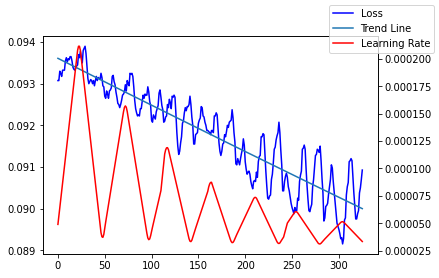

In [103]:
import matplotlib.pyplot as plt
import numpy as np

def smooth(data, window_width):
    ret = np.cumsum(np.insert(data, 0, 0)) 
    return (ret[window_width:] - ret[:-window_width]) / window_width
    
smooth_window = 4

start_idx = 0
smooth_loss = smooth(losses[start_idx:], smooth_window)
smooth_learning = smooth(learning_rates[start_idx:], smooth_window)

x_vals = np.arange(0, len(smooth_loss))
a, y = np.polyfit(x_vals, np.log(smooth_loss), 1)
print(smooth_loss)
print(smooth_learning)
x_vals = np.arange(0, len(smooth_loss))

def predicted_value(x, a, y):
    return np.exp(a*x) * np.exp(y)

y_vals = predicted_value(x_vals, a, y)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(smooth_loss, label="Loss", color="blue")
ax1.plot(x_vals, y_vals, label="Trend Line")
ax2.plot(smooth_learning, label="Learning Rate", color="red")

fig.legend()
fig.show()

print(f"y = {a}x + {y}")

future = predicted_value(0, a, y)
print("data start", future, np.exp(future))

future = predicted_value(len(smooth_loss), a, y)
print("data end", future, np.exp(future))

total_batches = 25232
print_rate = 500
one_epoch = total_batches/print_rate
future = predicted_value(len(smooth_loss) + one_epoch//2, a, y)
print("+0.5 epoch", future, np.exp(future))

future = predicted_value(len(smooth_loss) + one_epoch, a, y)
print("+1 epoch", future, np.exp(future))

future = predicted_value(len(smooth_loss) + one_epoch*2, a, y)
print("+2 epoch", future, np.exp(future))